<h1><center>Prediction of Volatility of S&P 500 Return with Long-Short Term Memory Neural Network for Value at Risk Model</center></h1>

<center> 43727, 48506</center><br>
<h3><center>Abstract</center><br>
    


This study evaluates the effectiveness of the LSTM Neural Network Model in predicting daily volatility for computation daily VaR, a measure used to compute the potential financial loss of an investment within a specific timeframe for risk management. To achieve this, we examined GARCH, Univariate, Multivariate, and LSTM-GARCH hybrid models for predicting daily volatility and used them to compute various versions of daily VaR.

After backtesting, the hybrid LSTM-GARCH model demonstrated superior performance in predicting daily volatility by incorporating GARCH, which captures the persistence of return volatility more effectively. Consequently, the predicted daily volatility from LSTM-GARCH (version 1) was chosen for computing daily VaR.



<br><br><br>
<h3><center>Intro</center></h3>

The purpose of this study is to evaluate the effectiveness of using the LSTM Neural Network Model to predict daily volatility for computing daily VaR. VaR is an important measure for assessing potential financial loss within a specific timeframe, which is crucial for risk management. We explored different models, including GARCH, Univariate LSTM, Multivariate LSTM, and a hybrid of LSTM and GARCH, to predict daily volatility.

To estimate the parameters of the models, we used sliding window cross-validation to optimize performance on different subsets of the time-series data. Among the models explored, LSTM-GARCH (version 1) performed the best in terms of test Mean Squared Error (MSE) and fitness to the data,as indicated by the plot of training and testing loss against epochs. Univariate LSTM came in second place, also performing well in terms of test MSE and fitness to the data.

We used the predicted daily volatility from both Univariate LSTM and LSTM-GARCH (version 1) to compute two versions of daily VaR. Ideally, daily VaR should accurately determine the percentage of days where the minimum loss threshold is breached within a specific period of time. However, our study found that daily VaR underestimated the actual return, which typically has a fatter tail than the returns assumed to be normally distributed. In particular, daily VaR computed from the predicted volatility of Univariate LSTM underestimated the actual return more than LSTM-GARCH (version 1).

This underestimation issue may be due to the higher persistence of return volatility at the start of the testing data period. However, the hybrid LSTM-GARCH model was better able to capture the persistence of return volatility and performed better overall. Therefore, we eventually chose the predicted daily volatility from LSTM-GARCH (version 1) for computing daily VaR.

<br><br><br>
#### Outline

#### 1.  Data Preparation <br>
1.1 Daily Log Closing Price</b> <br>
1.2 Daily Log Return <br>
1.3 GARCH Estimated Daily Volatility of S&P500 Return <br>
1.4 Combine Data of Daily Return with Data of GARCH Estimated Daily Volatility <br>
1.5 Data Splitting <br>
1.6 Loss Function <br>

#### 2.  Comparison of GARCH Model, Univariate and Multivariate LSTM Neural Network <br>
2.1 GARCH(1,1) model<br>
2.2 LSTM <br>
2.3 Univariate LSTM <br>
2.4 Multivariate LSTM<br>

#### 3.  A Hybrid of GARCH Model and LSTM Neural Network
3.1 GARCH + LSTM (version 1)
3.2 GARCH + LSTM (version 2)

#### 4. Results and Findings
4.1 Comparison of Mean Squared Error <br>
4.2 Computation of Value at Risk (VaR) <br>
4.3 Backtesting <br>

#### 5. Conclusion
#### 6. References

In [1]:
import copy
import random
from tqdm import tqdm
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from arch import arch_model
from arch.__future__ import reindexing
import torch
import torch.nn as nn

pd.set_option('display.max_columns', None) 

## 1.  Data Preparation 

-  Create an object, `ys` to store a list of 10 arrays. The data of 10 arrays is as follows: <br>
1. S&P500 daily return <br>
2. Apple daily return <br> 
3. Google daily return <br>
4. Microsoft daily return <br>
5. Amazon daily return <br>
6. Meta daily return <br>
7. Berkshire Hathaway daily return <br>
8. Exxon Mobil Corp daily return <br>
9. Nvidia daily return <br>
10. GARCH estimated daily volatility of S&P500 return <br><br>
- Each array contains data of 5 years (1257days).

<b>1.1 Daily Log Closing Price </b>

`snps` consists of daily closing prices of S&P 500 and its constituents: Apple, Google, Microsoft, Amazon, Meta, Berkshire Hathaway, Exxon Mobil Corp and Nvidia.

In [2]:
def load_data(ticker_names): # function to dowload closing price data 
    data = [
        yf.Ticker(ticker_name).history(period="5y", interval="1d")[["Close"]] 
        for ticker_name in ticker_names
    ]
    return data


# select S&P 500 and its constituents:
ticker_names = ["^GSPC", 
                "AAPL", 
                "GOOGL", 
                "MSFT", 
                "AMZN", 
                "META", 
                "BRK-B", 
                "XOM", 
                "NVDA"]

snps = load_data(ticker_names=ticker_names)

Note: 'info' dict is now fixed & improved, 'fast_info' no longer faster


Plot daily closing price of S&P 500 and its constituents against year.

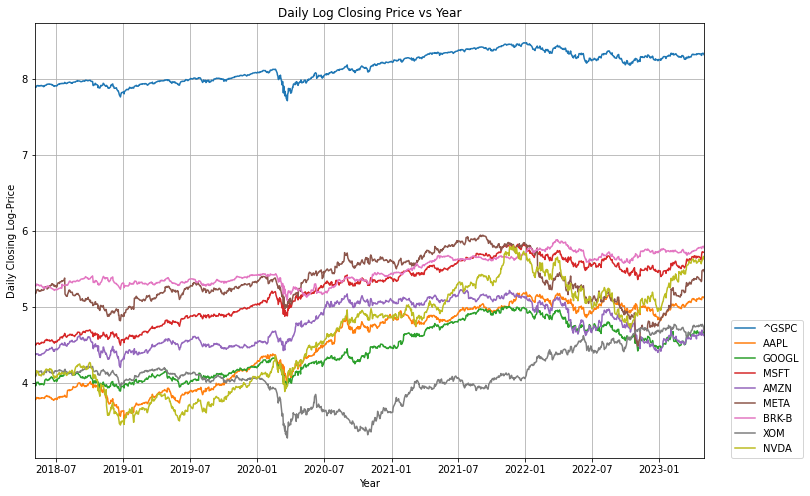

In [3]:
plt.figure(figsize=(12,8))

for i,snp in enumerate(snps):
    snp = np.log(snp)
    snps[i] = snp
    plt.plot(snp["Close"])

plt.title('Daily Log Closing Price vs Year')
plt.xlabel('Year')
plt.ylabel('Daily Closing Log-Price')

plt.grid(True)
plt.autoscale(axis='x',tight=True)
plt.legend(ticker_names,loc=(1.04, 0))

plt.show()

From the plot of daily log-closing price vs year, there are different trends at different timing for the price. Price seems to be not stationary, i.e. mean and variance of the time series are time-dependent. <br>
$\therefore$ it is difficult to find the period to compute the summary statistics. <br><br>

Compute the percentage of return, $x_{t}$ using the formula as follows:

\begin{equation}
\begin{split}
x_t  &= log\left(\frac{p_t-p_{t-1}}{p_{t-1}}\right)*100\\
  &\approx log\left(\frac{p_t}{p_{t-1}}\right)*100
\end{split} 
\end{equation}  <br><br>
$p_t$: price today <br>
$p_{t-1}$: price yesterday <br><br>
$\because p_{t} - p_{t-1}$ is negligible

<b>1.2 Daily Log Return </b>

`rets` is the daily returns of S&P 500 and its constituents.

In [4]:
rets = []
for snp in snps:
    ret = snp.diff() *100
    ret = ret.tail(-1) 
    ret.rename(columns={"Close": "Return"}, inplace = True) 
    rets.append(ret)

Plot daily return of S&P 500 and its constituents against year.

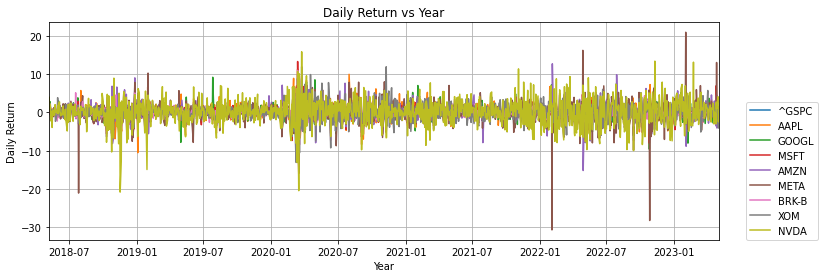

In [5]:
plt.figure(figsize=(12,4))
for ret in rets:
    plt.plot(ret["Return"])

plt.title('Daily Return vs Year')
plt.xlabel('Year')
plt.ylabel('Daily Return')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
plt.legend(ticker_names,loc=(1.04, 0))

plt.show()

Based on the plot of daily return against year, the daily return appears to be time-dependent, i.e. volatility is large or small in certain periods. However, the volatility clustering patterns seem to repeat itself over the years and mean of return is close to 0. <br>
$\therefore$  Returns data is used instead of closing price as statisical modelling is easier to perform on returns which seem to be stationary.

<b>1.3 GARCH Estimated Daily Volatility of S&P500 Return </b>

Geneneralised Autoregressive Conditional Heteroscedastic Model(GARCH) has 1 order of autoregressive terms and 1 order of moving average terms, <br>_s.t._ $x_t$ ~ $GARCH(1,1)$, 

\begin{equation}
\begin{split}
x_t        & = \sigma_t\epsilon_t\\
\sigma_t^2 & = \alpha_0 + \alpha_1x_{t-1}^2 + \beta_1\sigma_{t-1}^2 
\end{split} 
\end{equation} 
<br>
where $\epsilon_t$ ~ $IID$(0,1), with $ \alpha_0> 0,$ $ \alpha_1,\beta_1>=0$ and $\sum_{max(p,q)}^{i=1} (\alpha_1+\beta_1)<1$<br>

GARCH model could overcome the persistency of the volatility of time series, i.e. if volatility is high today, then volatility will be high tomorrow. GARCH model not only includes yesterday squared return, $x_{t-1}^2$, but also yesterday variance, $\sigma_{t-1}^2$ in the prediction of variance, $\sigma^2_t$ at time $t$. Prediction of daily volailtiy, $\sigma_t$ can be obtained by $\sqrt{\sigma_t^2}.$
<br><br>

Use GARCH(1,1) model to predict daily volatility of return for S&P 500. Store the daily estimated volatility in `sliding_prediction`. <br><br>

Sliding window is used to predict daily volatility of 1-day ahead. If window size is 10, then 1st, 2nd, 3rd.. 10th row of the training data is used to predict the 11th row of data. Then, 2nd,3th,.. 11th row of the training data is used to predict the 12th row of data. This process repeats till the end of the return data,`ret`.

Note that we use 6 years or 1499 trading days of daily S&P 500 return data to predict daily volatility instead of 5 years (Further explanation would be elaborated later).


In [6]:
window_size = 10

def extract_garch_volatity(ticker_name="^GSPC"):
    
    # download 6 years of daily price for S&P500
    snp = yf.Ticker(ticker_name).history(period="6y", interval="1d")[["Close"]] 
    snp.set_index(pd.DatetimeIndex(snp.index), inplace=True) 
    snp.rename(columns={"Close": "snp_close"}, inplace = True)
    snp = np.log(snp) # log price
    ret = snp.diff() *100 # %log return
    ret = ret.tail(-1) 
    ret.rename(columns={"snp_close": "snp_return"}, inplace = True) 
    sliding_predictions_gspc = [] 
    sliding_dates = [] 

    for i in range(len(ret) - window_size): 
        train_seq = ret[i:i+window_size] 
        arch = arch_model(train_seq, p=1, q=1, rescale = False) # define garch(1,1) model
        fit = arch.fit(disp='off') # fit the model
        
        # predict next day variance and convert variance as volatility
        pred = fit.forecast(horizon=1)
        sliding_predictions_gspc.append(np.sqrt(pred.variance.values[-1,:][0]))
        sliding_dates.append(ret.index[i+window_size]) 

    return sliding_dates, sliding_predictions_gspc

sliding_dates, sliding_predictions_gspc = extract_garch_volatity(ticker_name="^GSPC")
print(len(sliding_predictions_gspc))

1499


Plot GARCH Estimated Daily Volatility of S&P 500 Return against the Year.

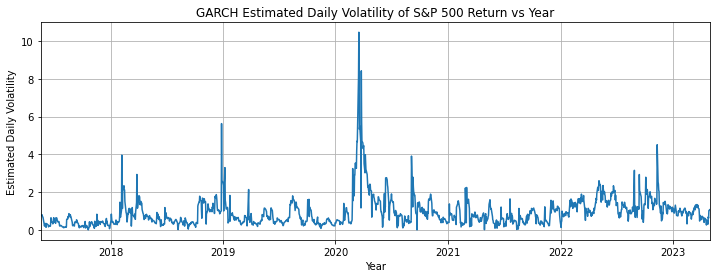

In [7]:
plt.figure(figsize=(12,4))
plt.plot(sliding_dates, sliding_predictions_gspc)
plt.grid(True)
plt.autoscale(axis='x',tight=True)
plt.xlabel("Year")
plt.ylabel("Estimated Daily Volatility")
plt.title("GARCH Estimated Daily Volatility of S&P 500 Return vs Year")
plt.show()

<b>1.4 Combine Data of Daily Return with Data of GARCH Estimated Daily Volatility </b>

Note that the length of `rets[0]` and `sliding_predictions` are of different lengths. `rets[0]` has length of 1257 as it has 5 years of data. `sliding_predictions_gspc` has length of 1499 as it has 6 years of data - window size. A year has 252 trading days. 5 years + 1 year - window size  = 1257 days + 252 days - 10 days = 1499 days.

- `rets[0]`: S&P500 return
-`sliding_predictions_gspc`: GARCH daily estimated volatilities of S&P500 return

In [8]:
print(f'number of S&P500 return is \
{len(rets[0])}.\nnumber of GARCH daily estimated volatilities of S&P500 return is \
{len(sliding_predictions_gspc)}.')

number of S&P500 return is 1257.
number of GARCH daily estimated volatilities of S&P500 return is 1499.


When we add the GARCH daily estimated volatilties of S&P500, `sliding_predictions_gspc `, to return of S&P500 and its constituent dataframe, `rets`, extract the most recent 1257 GARCH daily estimated volatilties. <br>

`ys` now consists of 
- return of S&P500 
- return of 8 constituents of S&P 500
- GARCH estimated daily volatiltiy of S&P 500 return 

In [9]:
ys = [ret["Return"].values.astype(float) for ret in rets]

# add garch volatility
ys += [np.array(sliding_predictions_gspc[-len(rets[0]):])]

<b>1.5 Data Splitting </b>

`rets[0]` is daily return data for S&P 500. There are 1257 rows for `rets[0]` . Use 25% of `rets[0]` as test size, which is 314.

In [10]:
test_size = round(0.25*len(rets[0]))
print(test_size, len(rets[0]))

314 1257


<b>1.6 Loss Function </b>

Use Mean Squared Error(MSE) for the loss function.

In [11]:
loss_fn = nn.MSELoss()

## 2.  Comparison of GARCH Model, Univariate and Multivariate LSTM Neural Network <br><br>
<b>2.1 GARCH(1,1) model</b>

- Use GARCH(1,1) model to predict daily volatility, $\sigma$ by inputting return in the model.

In [12]:
# train set for S&P500 return, return of 8 constituents and GARCH estimated volatility
train_sets = [y[:-test_size] for y in ys] 
# train set for S&P500 return, return of 8 constituents and GARCH estimated volatility
test_sets = [y[-test_size:] for y in ys]
train_set = train_sets[0] # train set for S&P500 return only
test_set = test_sets[0] # test set for S&P500 returnonly

def GARCH(window_size):
    sliding_predictions= [] # store the predictions in the list

    for i in range(len(ret) - window_size): 
        train_seq = ret[i:i+window_size] 
        arch = arch_model(train_seq, p=1, q=1, rescale = False) # define garch(1,1) model
        fit = arch.fit(disp='off') # fit the model on training data
        # predict variance using estimated parameters using training data
        pred = fit.forecast(horizon=1) 
        # convert variance to volatility
        sliding_predictions.append(np.sqrt(pred.variance.values[-1,:][0])) 

    sliding_predictions = pd.Series(sliding_predictions, index=ret.index[window_size:])

    # convert data from array to tensor
    y_train_g = np.array(train_set)
    y_train_g = torch.FloatTensor(y_train_g).view(-1)
    y_test_g = np.array(test_set)
    y_test_g = torch.FloatTensor(y_test_g).view(-1)
    
    # elements before last 314(test size)
    train_pred = torch.FloatTensor(np.array(sliding_predictions[:-test_size]))
    
    # elements for last 314
    test_pred = torch.FloatTensor(np.array(sliding_predictions[-test_size:]))
    
    # compute the loss function
    # elements after 10th (window size) element
    train_loss_g = loss_fn(np.sqrt(y_train_g[window_size:]**2),train_pred)
    test_loss_g = loss_fn(np.sqrt(y_test_g**2),test_pred)
    
    # plot the predicted volatilites and true returns against year
    plt.figure(figsize=(12,4))
    true, = plt.plot(ret[-len(ret):])
    preds, = plt.plot(sliding_predictions[-test_size:])
    plt.title('Volatility Prediction - Sliding Window')
    plt.legend(['True Returns', 'Predicted Volatility'])
    plt.xlabel('Year')
    plt.ylabel('Predicted Volatilities or True Returns')
    plt.grid(True)
    plt.autoscale(axis='x',tight=True)
    plt.show()
    
    # zoom in 
    plt.figure(figsize=(12,4))
    true, = plt.plot(ret[-test_size:])
    preds, = plt.plot(sliding_predictions[-test_size:])
    plt.title('Volatility Prediction - Sliding Window')
    plt.legend(['% of True Returns', 'Predicted Volatilities'])
    plt.xlabel('Year')
    plt.ylabel('Predicted Volatilities or True Returns')
    plt.grid(True)
    plt.autoscale(axis='x',tight=True)
    plt.show()
    print(f'For window size of {window_size}, MSE(train):{train_loss_g:.4f}, MSE(test):{test_loss_g:.4f}.')
    
    return train_loss_g,test_loss_g,sliding_predictions

    

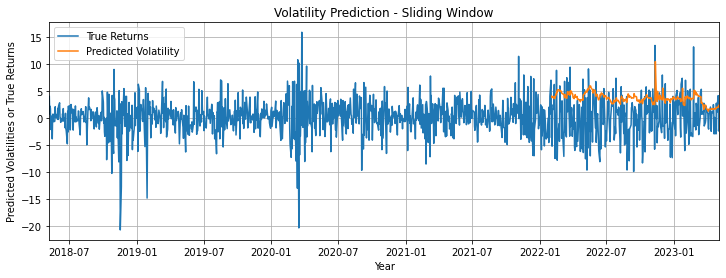

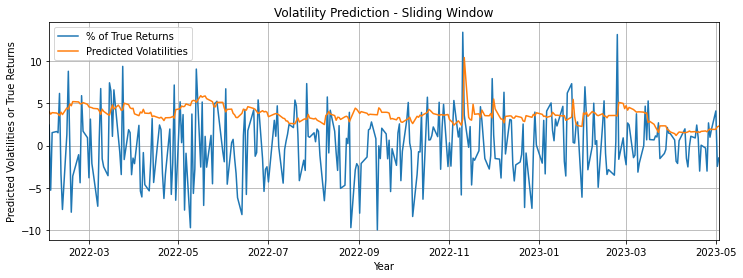

For window size of 20, MSE(train):5.4200, MSE(test):7.9270.


In [13]:
_,_,_ = GARCH(20)

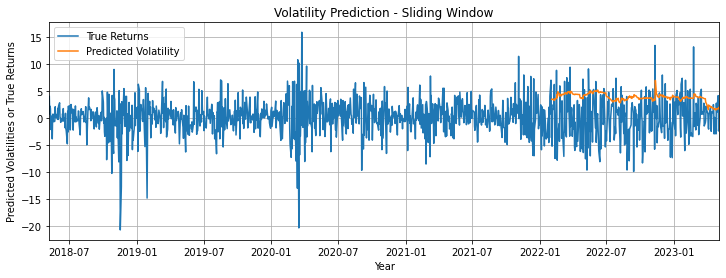

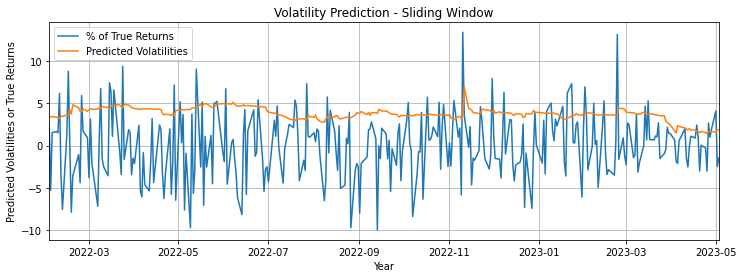

For window size of 50, MSE(train):5.7650, MSE(test):8.1973.


In [14]:
_,_,_ = GARCH(50)

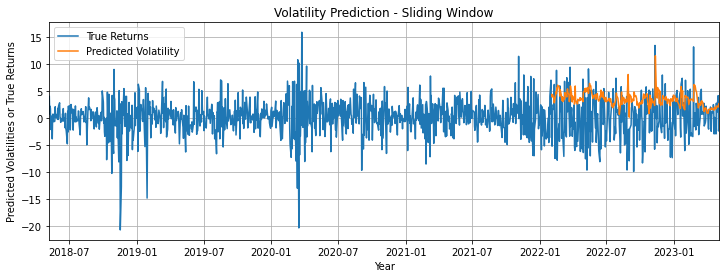

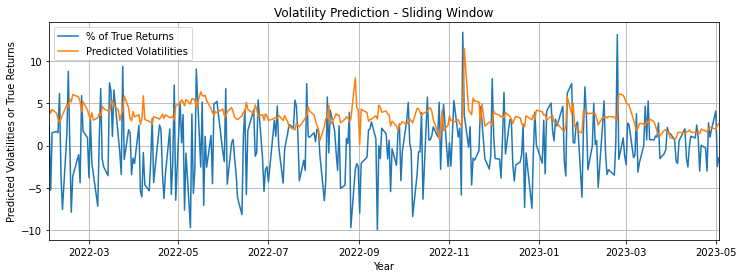

For window size of 10, MSE(train):5.5041, MSE(test):7.6347.


In [15]:
train_loss_g, test_loss_g, vola = GARCH(10) # len(vola) = 1247 (1257 - window size)

GARCH(1,1) seems to perform best in term of lowest MSE for training and test set with a window size of 10.

The higher the % of return, the higher the estimated volatility.

<b>2.2 LSTM</b>

1. LSTM a type of Recurrent Neural Network(RNN) which is designed to avoid issues of exploding or vanishing gradient as the networks grow deeper and more complex <br>
2. RNN "forgets" the 1st input as there is information loss at each step going through RNN and long-term memory is needed

- RNN has a single neural network layer<br><br>
$H_t = tanh(W[H_{t-1},X_{t}]+b)$, where <br><br>
$x_t$ : input t <br>
$H_{t-1}$ : output t-1 <br>
$H_t$: output t <br>
$W$ : weight<br>
$b$: bias<br>


3. LSTM is a combination of Long Term and Short Term Memories <br>


- LSTM has 4 neural network layers <br><br>
\begin{aligned}
 f_t &= \sigma(W_f[h_{t-1},x_t] + b_f) \\\\
 i_t &= \sigma(W_i[h_{t-1},x_t] + b_i) \\
\tilde{C}t &= \tanh(W_c[h_{t-1},x_t] + b_c) \\\\
C_t &= f_t * C_{t-1} + i_t * \tilde{C}t \\\\
o_t &= \sigma(W_o [h_{t-1},x_t] + b_o) \\
h_t &= o_t * \tanh(C_t)
\end{aligned} <br>



$x_t$    :Input at time t <br>
$h_t$    : Output at time t <br>
$c_{t-1}$: Long-term memory <br>
$c_{t}$  : New long-term memory <br>
$h_{t-1}$: Short-term memory <br>
$h_t$    : New- short-term memory <br>

sigmoid activation function, $\sigma(x) = \frac{e^x}{1+e^x}$ for output between 0 and 1<br>
tangent activation function, $tanh(x) = \frac{e^x-e^{-x}}{e^x+e{-x}}$ for output between -1 and 1



_1st stage: Forget-Gate,$f_t$_
- determine % of long-term memory remembered

_2nd stage: Input-Gate</b> $i_t*\tilde{C}_t$_

- determine the updated value of the long-term memory _s.t._ <br>
updated value                  = % potential memory to remember, $i_t$ * potential long-term memory, $\tilde{C}_t$ <br>

_3rd stage: Update Old Cell State </b>, $C_t$_
- long-term memory * output from 1st stage + output from 2nd stage

_4th stage: Output-Gate_
- determine the output of LSTM called New Short-Term Memory <br>
[tanh(output from 3rd stage)] *
[sigmoid(%potential memory to remember)]
<br><br>

Recall that `ys` stores a list of 10 arrays. The data of 10 arrays is as follows: <br>
1. S&P500 daily return <br>
2. Apple daily return <br> 
3. Google daily return <br>
4. Microsoft daily return <br>
5. Amazon daily return <br>
6. Meta daily return <br>
7. Berkshire Hathaway daily return <br>
8. Exxon Mobil Corp daily return <br>
9. Nvidia daily return <br>
10. GARCH estimated daily volatility of S&P500 return <br><br>
- Each array contains data of 5 years (1257days).

fit_transform( ) of MinMaxScaler is used to scale the training data. Apply transform( ) to scale the test data using the same scaling parameters learned from the training data.`ns` is now the scaled version of `ys` and a FloatTensor.

In [16]:
scaler = MinMaxScaler(feature_range=(-1, 1))
scaler = scaler.fit(np.hstack(ys).reshape(-1,1))
ns = [scaler.transform(tmpy.reshape(-1,1)) for tmpy in ys]
ns = [torch.FloatTensor(tmpn) for tmpn in ns]

Define a sliding window cross validation function. This function works the same as the sliding window defined above.

In [17]:
def sliding_window(num ,window_size):
    output = []
    l = len(num)
    for i in range(l-window_size):
        window = num[i:i+window_size]
        # volatiltiy = square root the square return
        label = torch.sqrt(num[i+window_size:i+window_size+1]**2)  
        output.append((window,label))
    return output

all_data = [sliding_window(tmpn, window_size) for tmpn in ns]

The original data had 1257 in length of time. Now, it becomes 1247 as the window size is 10. 

In [18]:
print("Sum of S&P500 return, returns of 8 constituents and estimated volatility: ", len(all_data))
print("Number of sliding windows for each of them : ", 
      *[len(tmpdata) for tmpdata in all_data])

Sum of S&P500 return, returns of 8 constituents and estimated volatility:  10
Number of sliding windows for each of them :  1247 1247 1247 1247 1247 1247 1247 1247 1247 1247


In [20]:
def chunk(data, no_of_features, batch_size=32):
    
    # for x, store return of all features
    x = [torch.stack([tmp[j][0] for j in range(no_of_features)] 
            ,axis=2) 
             for tmp in data]
    
    # for y, store return for S&P 500
    y = [tmp[0][1] for tmp in data] 
    
    # for both x & y, [0,1,2,3,4,5,6....1246] -> [[0,...,31],[32,...,63]]
    batch_x = [x[i*batch_size:(i+1)*batch_size] 
         for i in range(len(x)//batch_size+int(len(x)%batch_size!=0))]
    
    batch_y = [y[i*batch_size:(i+1)*batch_size] 
         for i in range(len(y)//batch_size+int(len(y)%batch_size!=0))]
    return batch_x,batch_y

e.g. If there are 3 stocks in the list, each stock is a list of all pairs of sliding windows (x,y). For easy shuffling, it is nice to group all (x,y) from different stocks together. 

[
"aapl":[(x1,y1),(x2,y2) ,....], <br>
"goog":[(x1,y1),(x2,y2) ,....], <br>
"msft":[(x1,y1),(x2,y2) ,....] 
],

<br><br>
group as <br>
<br>

[
[
((x2,y2),(x2,y2),(x2,y2)), <br>
((x3,y3),(x3,y3),(x3,y3))  <br>
((x1,y1),(x1,y1),(x1,y1)),
], where <br><br>

x1 = apple(r1,r2,r3,r4,5...10) <br>
x1 = googl(r1,r2,r3,r4,5...10) <br>
x1 = msft(r1,r2,r3,r4,5...10)  <br>


In [21]:
def convert_arr_for_shuffle_batch(data, no_of_features):
    return [[data[j][i] for j in range(no_of_features)] 
                         for i in range(len(data[0]))]

In [22]:
def select_features(data, no_of_features, batch_size=32): 
    all_data_easy_shuffle = convert_arr_for_shuffle_batch(data, 
                no_of_features=no_of_features)
    return chunk(all_data_easy_shuffle, 
        no_of_features=no_of_features, batch_size=batch_size)

In [23]:
xbatch,ybatch = select_features(all_data, no_of_features = 10)
print("Number of batches: ", len(xbatch), len(ybatch))
print("First batch size: ", len(xbatch[0]))
print("Last batch size: ", len(xbatch[-1]))
print("Last batch first group: ", len(xbatch[-1][0]))
print("Last batch first group: ", xbatch[-1][0], ybatch[-1][0])

Number of batches:  39 39
First batch size:  32
Last batch size:  31
Last batch first group:  10
Last batch first group:  tensor([[[ 0.1284,  0.1316,  0.1361,  0.1470,  0.1800,  0.1801,  0.1160,
           0.1126,  0.1449,  0.2202]],

        [[ 0.1937,  0.2206,  0.2043,  0.1814,  0.2036,  0.1979,  0.1914,
           0.1312,  0.3342,  0.2280]],

        [[ 0.1160,  0.1300,  0.1080,  0.1671,  0.1187,  0.1189,  0.1058,
           0.1582,  0.0669,  0.2256]],

        [[ 0.1317,  0.1341,  0.1166,  0.1305,  0.1238,  0.1414,  0.1731,
           0.1400,  0.1095,  0.2333]],

        [[ 0.1824,  0.2394,  0.2087,  0.2705,  0.2602,  0.2182,  0.1787,
           0.1434,  0.1884,  0.2353]],

        [[ 0.2516,  0.2425,  0.3081,  0.2918,  0.2897,  0.4598,  0.2195,
           0.2028,  0.3692,  0.2299]],

        [[ 0.1611,  0.1984,  0.2756,  0.2568,  0.2418,  0.2621,  0.0925,
          -0.0096,  0.2148,  0.2390]],

        [[ 0.2558,  0.2601,  0.3545,  0.3424,  0.3401,  0.3266,  0.2417,
           0.1

In [24]:
class LSTM(nn.Module):
    
    def __init__(self,
                 input_size=1,
                 hidden_size=64,
                 num_layers=1,
                 window_size=10,
                 dropout_ratio=0.1,
                 output_size=1):
        
        
        super().__init__() 
        self.input_size = input_size
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.window_size = window_size
        
        self.lstm = nn.LSTM(input_size,
                            hidden_size,
                            num_layers)
        self.dropout = nn.Dropout(p=dropout_ratio)
        
        self.linear = nn.Linear(hidden_size*window_size,output_size)
        
# (64,2,64) -> (2,64,64)-> (2,64x64)
    def forward(self,num): 

        # (10,2) = (window_size, batch_size)
        # view -> (10,2,1)
        lstm_out, _ = self.lstm(
            num.view(self.window_size,-1,self.input_size))
        # (10,2,64)
        lstm_out = lstm_out.transpose(0,1)
        # (2,10,64)

        lstm_out = lstm_out.reshape(-1, self.window_size*self.hidden_size)
        # (2,640)
        #print(lstm_out.shape)

        lstm_out = self.dropout(lstm_out)
        
        pred = self.linear(lstm_out)
        # (2,1)
        
        return pred  

In [25]:
class Pipeline:
    def __init__(self,
          sliding_data,
          batch_size=32, 
          num_of_features=3, 
          num_of_epochs=1000,
          dropout_ratio=0.1,
          num_layers=1,
          test_size=314):
        self.sliding_data = sliding_data
        self.batch_size = batch_size
        self.num_of_features = num_of_features
        self.num_of_epochs = num_of_epochs
        self.test_size = test_size
        self.model = LSTM(input_size=self.num_of_features, 
                          output_size=1, num_layers=num_layers,
                          dropout_ratio=dropout_ratio)
        self.adam = torch.optim.Adam(self.model.parameters(), 
                        lr=0.001)
        self.loss_fn = nn.MSELoss()
        self.min_model = None
        self.min_loss = float("inf")
        self.min_epoch = 0
        
    def train(self):
        torch.manual_seed(101)
        
        train_data = [self.sliding_data[i][:-self.test_size] 
                      for i in range(self.num_of_features)]
        test_data = [self.sliding_data[i][-self.test_size:] 
                     for i in range(self.num_of_features)]
        self.train_data = convert_arr_for_shuffle_batch(
            train_data, no_of_features=self.num_of_features)
        self.test_data = convert_arr_for_shuffle_batch(
            test_data, no_of_features=self.num_of_features)
        self.bx_test, self.by_test = chunk(test_data, 
            no_of_features=self.num_of_features)

        self.loss_values, self.loss_values_test = [], []
        for i in tqdm(range(self.num_of_epochs)):
            random.shuffle(self.train_data)
            bx, by = chunk(self.train_data, 
                no_of_features=self.num_of_features)

            self.model.train()
            accumulate_loss_per_epoch = 0
            accumulate_i = 0
            for xdata, ydata in zip(bx,by):
                self.adam.zero_grad()
                xdata = torch.cat(xdata,1)
                ydata = torch.cat(ydata,0)
                ypred = self.model(xdata)

                loss = self.loss_fn(ypred, ydata)
                loss.backward()
                self.adam.step()

                accumulate_loss_per_epoch += loss.item()
                accumulate_i += 1

            self.loss_values.append(accumulate_loss_per_epoch/accumulate_i)

            self.model.eval() # evaluation mode
            accumulate_loss_per_epoch = 0
            accumulate_i = 0

            with torch.no_grad():
                for xdata, ydata in zip(self.bx_test, self.by_test):
                    xdata = torch.cat(xdata,1)
                    ydata = torch.cat(ydata,0)
                    ypred = self.model(xdata)
                    loss = self.loss_fn(ypred, ydata)

                    accumulate_loss_per_epoch += loss.item()
                    accumulate_i += 1
                avg_loss_test = accumulate_loss_per_epoch/accumulate_i
                self.loss_values_test.append(avg_loss_test)
                if avg_loss_test < self.min_loss:
                    self.min_epoch = i
                    self.min_loss = avg_loss_test
                    self.min_model = copy.deepcopy(self.model)

    def plot_losses(self):
        plt.figure(figsize=(12,4))
        plt.plot(self.loss_values)
        plt.plot(self.loss_values_test)
        plt.legend(['train','test'])
        plt.title('Loss against Epochs')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.grid(True)
        plt.autoscale(axis='x',tight=True)
        
    def plot_predictions(self, mode='best'):
        
        data_prepare_shuffle_batch = convert_arr_for_shuffle_batch(
            self.sliding_data, no_of_features=self.num_of_features)
        bx, by = chunk(data_prepare_shuffle_batch, 
            no_of_features=self.num_of_features)
        preds_data = []
        with torch.no_grad():
            for xdata, ydata in zip(bx, by):
                xdata = torch.cat(xdata,1)
                ydata = torch.cat(ydata,0)
                if mode=='last':
                    ypred = self.model(xdata)
                elif mode=='best':
                    ypred = self.min_model(xdata)
                preds_data += np.array(ypred).squeeze().tolist()
        
        inverse_preds_data = scaler.inverse_transform([preds_data])
        plt.figure(figsize=(12,4))
        plt.plot(np.array(rets[0].index[window_size:]), ys[0][window_size:])
        plt.plot(np.array(rets[0].index[window_size:]), np.sqrt(inverse_preds_data[0]**2))
        plt.title('Volatility Prediction - Sliding Window')
        plt.legend(['% of True Returns', 'Predicted Volatilities'])
        plt.xlabel('Year')
        plt.ylabel('Predicted Volatilities or True Returns')
        plt.grid(True)
        plt.autoscale(axis='x',tight=True)
        
        train_loss = experiment1.loss_fn(
            torch.FloatTensor(np.sqrt(((ys[0][window_size:-test_size]))**2)).view(-1),
            torch.FloatTensor(np.sqrt(((inverse_preds_data[0][:-test_size]))**2)).view(-1))
        
        test_loss = experiment1.loss_fn(
            torch.FloatTensor(np.sqrt(((ys[0][-test_size:]))**2)).view(-1),
            torch.FloatTensor(np.sqrt(((inverse_preds_data[0][-test_size:]))**2)).view(-1))
            
        print("Train and Test Loss: ", train_loss, test_loss)
        return inverse_preds_data, train_loss, test_loss

<b>2.3 Univariate LSTM </b>
- GARCH(1,1) model to predict daily volatility, $\sigma$ by inputting return in the model. Using the same concept, use LSTM to predict S&P500 daily volatility, $\sigma$ with historical S&P500 return.

In [26]:
experiment1 = Pipeline(all_data,
    batch_size=32, 
    num_of_features=1, 
    num_of_epochs=1000,
    dropout_ratio=0.3,
    num_layers=1)
experiment1.train()

100%|███████████████████████████████████████| 1000/1000 [02:34<00:00,  6.45it/s]


Plot loss for normalized daily volatility against epochs.

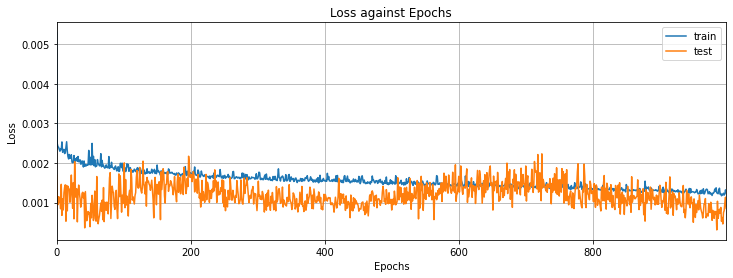

In [27]:
experiment1.plot_losses()

The loss of training set decreases steadily and reaches to a plateau. The loss for testing set fluctuates but eventually decreases to a point of stability with a small gap with the train loss. The fit is decent despite using only a feature for prediction.

Plot predicted daily volatility and true return (%)  against epochs for train and test set.

Train and Test Loss:  tensor(0.8628) tensor(1.5006)


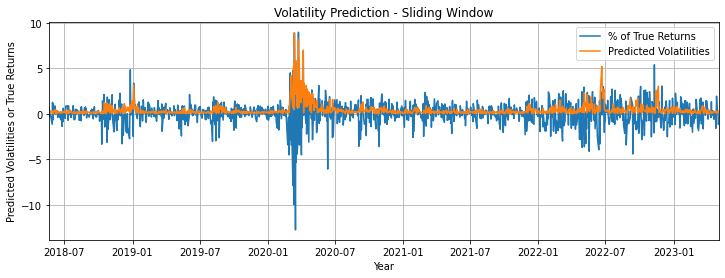

In [28]:
preds_unnorm1, _, _ = experiment1.plot_predictions()

The MSE for training is small and the MSE for testing is not relatively too large, suggesting a decent fit.

Zoom in the plot of predicted daily volatility and true return (%) against epochs for test set.

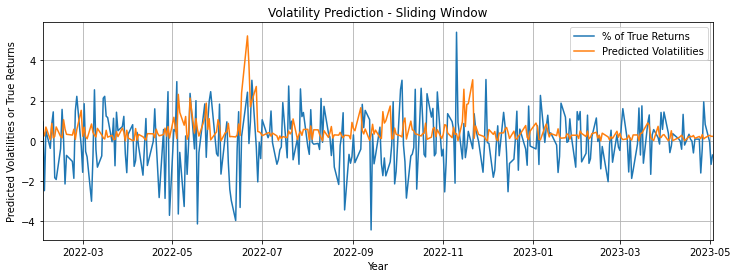

In [29]:
plt.figure(figsize=(12,4))
plt.plot(np.array(rets[0].index[-test_size:]),ys[0][-test_size:])
plt.plot(np.array(rets[0].index[-test_size:]),np.sqrt(preds_unnorm1[0][-test_size:]**2))
plt.title('Volatility Prediction - Sliding Window')
plt.legend(['% of True Returns', 'Predicted Volatilities'])
plt.xlabel('Year')
plt.ylabel('Predicted Volatilities or True Returns')
plt.grid(True)
plt.autoscale(axis='x',tight=True)

The higher the % of return, the higher the predicted volatility.

<b>2.4 Multivariate LSTM</b>
- use LSTM to predict S&P500 daily volatility, $\sigma$ with 
1. S&P500 daily return
2. Apple daily return
3. Google daily return
4. Microsoft daily return
5. Amazon daily return
6. Meta daily return
7. Berkshire Hathaway daily return
8. Exxon Mobil Corp daily return
9. Nvidia daily return


In [30]:
len(ticker_names)

9

In [31]:
experiment2 = Pipeline(all_data,
    batch_size=32, 
    num_of_features=len(ticker_names), 
    num_of_epochs=1000,
    dropout_ratio=0.3,
    num_layers=1)
experiment2.train()

100%|███████████████████████████████████████| 1000/1000 [02:54<00:00,  5.73it/s]


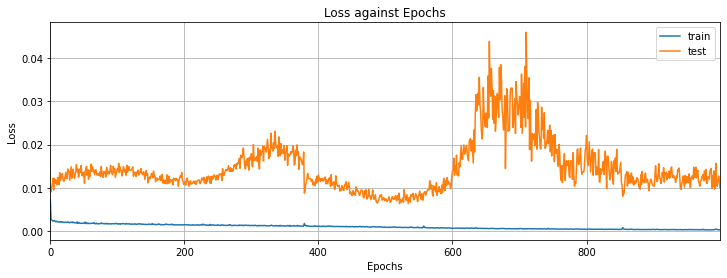

In [32]:
experiment2.plot_losses()

The loss of training set is not actually decreasing whereas the loss for testing set is fluctuating. The model might be overfitting to training data and unable to generalize well on testing data. 

Train and Test Loss:  tensor(0.6071) tensor(1.6375)


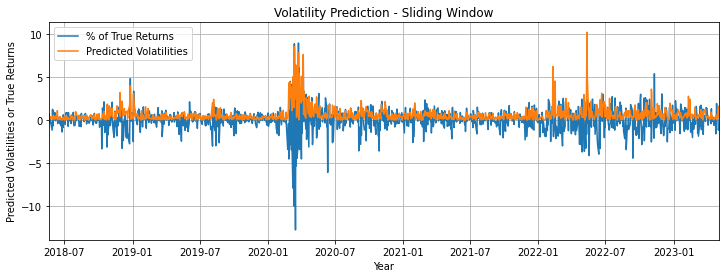

In [33]:
preds_unnorm2, _, _ = experiment2.plot_predictions()

The MSE for training is small but the MSE for testing data is large, suggesting overfitting.

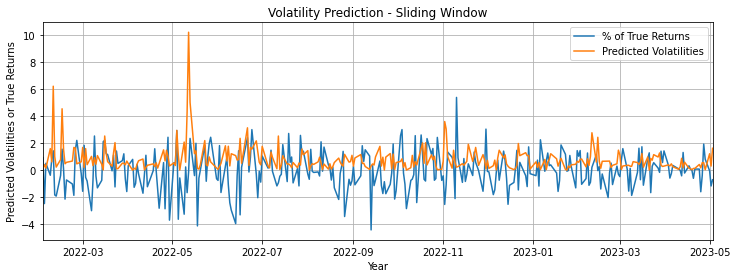

In [34]:
plt.figure(figsize=(12,4))
plt.plot(np.array(rets[0].index[-test_size:]),ys[0][-test_size:])
plt.plot(np.array(rets[0].index[-test_size:]),np.sqrt(preds_unnorm2[0][-test_size:]**2))
plt.title('Volatility Prediction - Sliding Window')
plt.legend(['% of True Returns', 'Predicted Volatilities'])
plt.xlabel('Year')
plt.ylabel('Predicted Volatilities or True Returns')
plt.grid(True)
plt.autoscale(axis='x',tight=True)

The higher the % of return, the higher the estimated volatility.

## 3.  A Hybrid of GARCH Model and LSTM Neural Network

Swap 2 with 10 <br>

_Original_
1. S&P500 daily return
2. Apple daily return
3. Google daily return
4. Microsoft daily return
5. Amazon daily return
6. Meta daily return
7. Berkshire Hathaway daily return
8. Exxon Mobil Corp daily return
9. Nvidia daily return
10. GARCH estimated daily volatility of S&P500 return

<br><br>


_Modified_
1. S&P500 daily return
2. GARCH estimated daily volatility of S&P500 return
3. Google daily return
4. Microsoft daily return
5. Amazon daily return
6. Meta daily return
7. Berkshire Hathaway daily return
8. Exxon Mobil Corp daily return
9. Nvidia daily return
10. Apple daily return

In [35]:
all_data_modified = all_data.copy()
all_data_modified[1], all_data_modified[-1] = \
    all_data_modified[-1], all_data_modified[1]

<b>3.1 GARCH + LSTM (version1) </b>
- use LSTM to predict S&P500 daily volatility, $\sigma$ with 
1. S&P500 daily return
2. GARCH estimated daily volatility of S&P500 return

In [36]:
experiment3 = Pipeline(all_data,
    batch_size=32, 
    num_of_features=2, 
    num_of_epochs=1000,
    dropout_ratio=0.3,
    num_layers=1)
experiment3.train()

100%|███████████████████████████████████████| 1000/1000 [03:04<00:00,  5.41it/s]


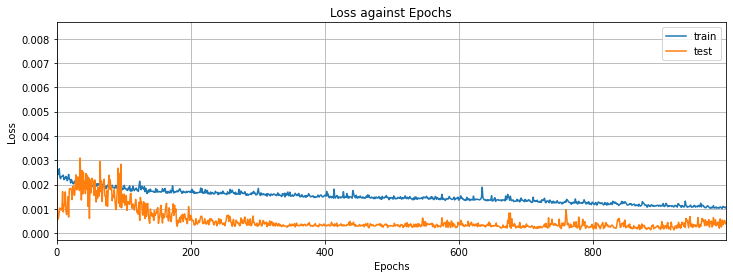

In [37]:
experiment3.plot_losses()

The loss of training set decreases steadily and reaches to a plateau. The loss for testing set decreases to a point of stability with a small gap with the train loss. The fit is decent despite using only a feature for prediction.

Train and Test Loss:  tensor(0.7878) tensor(1.6204)


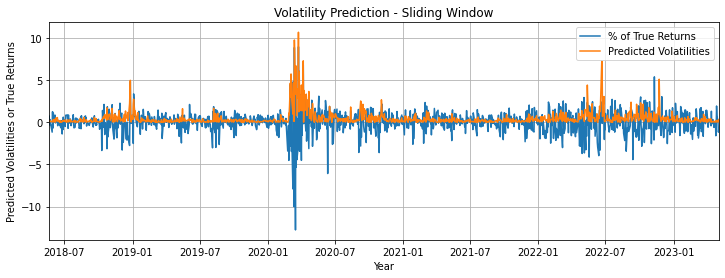

In [38]:
preds_unnorm3, _, _ = experiment3.plot_predictions()

The MSE for training is small and the MSE for testing is not too large, suggesting a decent fit.

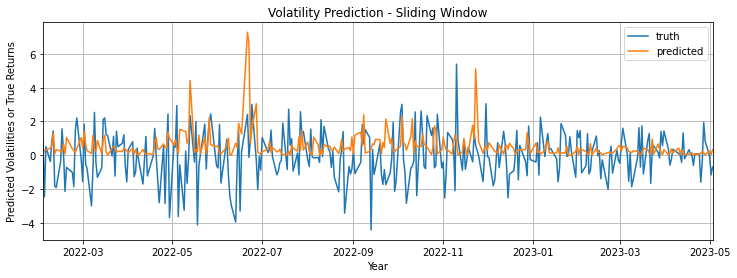

In [39]:
plt.figure(figsize=(12,4))
plt.plot(np.array(rets[0].index[-test_size:]),ys[0][-test_size:])
plt.plot(np.array(rets[0].index[-test_size:]),np.sqrt(preds_unnorm3[0][-test_size:]**2))
plt.title('Volatility Prediction - Sliding Window')
plt.legend(['% of True Returns', 'Predicted Volatilities'])
plt.xlabel('Year')
plt.ylabel('Predicted Volatilities or True Returns')
plt.legend(['truth', 'predicted'])
plt.grid(True)
plt.autoscale(axis='x',tight=True)

The higher the % of return, the higher the estimated volatility.

<b>3.2 GARCH + LSTM (version 2)</b>

- use LSTM to predict S&P500 daily volatility, $\sigma$ with 
1. S&P500 daily return
2. GARCH estimated daily volatility of S&P500 return
3. Google daily return
4. Microsoft daily return
5. Amazon daily return
6. Meta daily return
7. Berkshire Hathaway daily return
8. Exxon Mobil Corp daily return
9. Nvidia daily return
10. Apple daily return

In [40]:
experiment4 = Pipeline(all_data,
    batch_size=32, 
    num_of_features=len(ticker_names)+1, 
    num_of_epochs=1000,
    dropout_ratio=0.3,
    num_layers=1)
experiment4.train()

100%|███████████████████████████████████████| 1000/1000 [03:31<00:00,  4.73it/s]


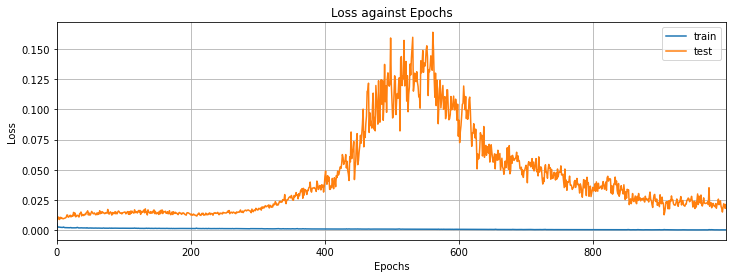

In [41]:
experiment4.plot_losses()

The loss of training set is not actually decreasing whereas the loss for testing set increases then decreases. The model might be overfitting to training data and unable to generalize well on testing data. 

Train and Test Loss:  tensor(1.2580) tensor(1.0497)


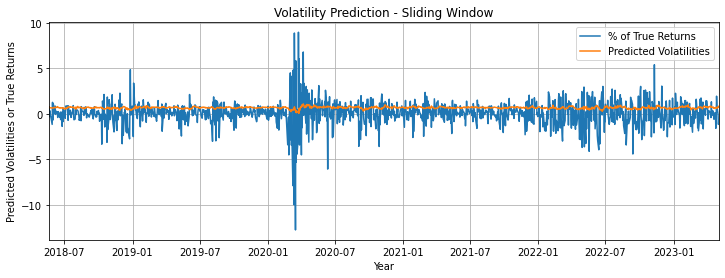

In [42]:
preds_unnorm4, _, _ = experiment4.plot_predictions()

In [ ]:
plt.figure(figsize=(12,4))
plt.plot(np.array(rets[0].index[-test_size:]),ys[0][-test_size:])
plt.plot(np.array(rets[0].index[-test_size:]),np.sqrt(preds_unnorm4[0][-test_size:]**2))
plt.title('Volatility Prediction - Sliding Window')
plt.legend(['% of True Returns', 'Predicted Volatilities'])
plt.xlabel('Year')
plt.ylabel('Predicted Volatilities or True Returns')
plt.legend(['truth', 'predicted'])
plt.grid(True)
plt.autoscale(axis='x',tight=True)

## 4. Results and Findings

<b>4.1 Comparison of Mean Squared Error</b>

<b>GARCH(1,1) Model</b> <br>
<b> Train RMSE:5.5401 </b> <br>
<b> Test RMSE:7.6347 </b>

- use GARCH(1,1) model to predict S&P500 daily volatility, $\sigma$ by inputting

1. historical S&P500 return.

<b>Univariate LSTM </b><br>
<b> Train RMSE: 0.8628 </b> <br>
<b> Test RMSE: 1.5006 </b>

- use LSTM to predict S&P500 daily volatility, $\sigma$ with 

1. historical S&P500 return.

<b> Multivariate LSTM</b><br>
<b> Train RMSE: 0.6071 </b> <br>
<b> Test RMSE: 1.6375 </b>

- use LSTM to predict S&P500 daily volatility, $\sigma$ with 
1. S&P500 daily return
2. Apple daily return
3. Google daily return
4. Microsoft daily return
5. Amazon daily return
6. Meta daily return
7. Berkshire Hathaway daily return
8. Exxon Mobil Corp daily return
9. Nvidia daily return

<b>GARCH + LSTM (version1) </b><br>
<b> Train RMSE: 0.7878</b> <br>
<b> Test RMSE: 1.6204 </b>
- use LSTM to predict S&P500 daily volatility, $\sigma$ with 
1. S&P500 daily return
2. GARCH estimated daily volatility of S&P500 return

<b>GARCH + LSTM (version 2) </b> <br>
<b> Train RMSE:1.2580 </b> <br>
<b> Test RMSE: 1.0497 </b>
- use LSTM to predict S&P500 daily volatility, $\sigma$ with 
1. S&P500 daily return
2. GARCH estimated daily volatility of S&P500 return
3. Google daily return
4. Microsoft daily return
5. Amazon daily return
6. Meta daily return
7. Berkshire Hathaway daily return
8. Exxon Mobil Corp daily return
9. Nvidia daily return
10. Apple daily return

<b> Best model </b> <br>
The best model in term of MSE, with the assumption that it provides a decent fit based on the loss against epoch plot is the univariate LSTM model.

<b> 4.2 Computation of Value at Risk (VaR)</b>

<b>daily VaR </b>

Computation of daily VaR is as follows: <br> 

daily VaR <br>
= mean daily return - ($Z\sigma$) <br>

Generally, mean daily return is small and close to 0;<br>

$\therefore$ daily VaR <br>
$\approx$($Z\sigma$) <br> 

Note: Get Z-value from Z Score Table, -ve sign is omitted here as it is computing loss

5% daily VaR is as follows:

In [44]:
Z = 1.65
# use average predicted volatility from univariate lstm 
daily_sigma = np.mean(np.sqrt(preds_unnorm1[-test_size:]**2)) 
daily_var = Z*daily_sigma
daily_var

0.66802494139764

In [45]:
# use average predicted volatility from lstm-garch(version 1)

daily_sigma2 = np.mean(np.sqrt(preds_unnorm3[-test_size:]**2)) 
daily_var2 = Z*daily_sigma2
daily_var2

0.7542927012729383

daily_sigma is the average predicted volality of 314 days (test size)

<b> portfolio value </b>


portfolio value <br>
= sum (units or shares of asset i x current market price of asset i), for i = 1 to n

If you buy 1 unit of S&P500 on the last day of training set, the price is $4546.540039. 

portfolio value <br>
= 1* $4546.540039

In [46]:
price_df = np.exp(snps[0])# inverse transform the log price
portfolio_value = price_df[-test_size-1:].iloc[[0]] # last day of training data
portfolio_value

,Close
Date,
2022-02-01 00:00:00-05:00,4546.540039


In [47]:
portfolio_value = portfolio_value.iloc[[0]].values[0].item()
portfolio_value

4546.540039062503

Expect a minimum amount of loss with 5% probability is as follow:

In [48]:
# univariate lstm
min_loss = daily_var/100*portfolio_value
min_loss

30.37202143156752

In [49]:
# lstm-garch(version 1)
min_loss2 = daily_var2/100*portfolio_value
min_loss2

34.29421967510026

<!-- Last day of training set -->

<b>4.3 Backtesting </b>

- backtest if daily VaR is good for 314 days (test size)

In [50]:
backtest_ret = price_df.diff().tail(-1)
backtest_ret.rename(columns={"Close":"Return"}, inplace = True)

backtest = backtest_ret[-test_size:]
backtest


,Return
Date,
2022-02-02 00:00:00-05:00,42.839844
2022-02-03 00:00:00-05:00,-111.939941
2022-02-04 00:00:00-05:00,23.089844
2022-02-07 00:00:00-05:00,-16.659668
2022-02-08 00:00:00-05:00,37.669922
...,...
2023-04-27 00:00:00-04:00,79.360107
2023-04-28 00:00:00-04:00,34.129883
2023-05-01 00:00:00-04:00,-1.609863


In 314 days of the test set, test if there are more than 5% of the days which have loss of more than $30.37202143156752

In [51]:
# univariate lstm
count = (backtest["Return"] < -min_loss).sum()
count

90

In 314 days of the test set, test if there are more than 5% of the days which have loss of more than $34.29421967510026

In [52]:
# lstm-garch(version 1)
count2 = (backtest["Return"] < -min_loss2).sum()
count2

79

There are more than 5% of the days which have loss of more than 30.37202143156752. It is an underestimated VaR where actual returns have fatter tails compared to normal distribution. Actual returns with fatter returns implies that there are more extreme returns compared to returns that are normally distributed. <br><br>

It is not surprising that the VaR model underestimated the period from 2022-02-02 onwards as the volatility is much more persistent from 2022-02-02.

In [53]:
# univariate lstm
count/(test_size)

0.28662420382165604

There are more than 5% of the days which have loss of more than $34.29421967510026.By incorporating GARCH estimated volatiltiy in the model, the performance is better as the persistency of volatility is capatured.

In [54]:
# lstm-garch(version 1)
count2/(test_size)

0.2515923566878981

## Conclusions

The LSTM-GARCH (version 1) model outperformed other models in terms of both test Mean Squared Error (MSE) and fitness to the data, as indicated by the training and testing loss plots. The Univariate LSTM model came in second place, also performing well in terms of MSE and fitness to the data.

Both models were used to predict daily volatility, which was then used to calculate two versions of daily VaR. However, the Univariate LSTM model underestimated the actual return more than LSTM-GARCH (version 1) did. This issue may be due to the higher persistence of return volatility at the start of the testing data period. Nevertheless, the hybrid LSTM-GARCH model was better able to capture the persistence of return volatility and performed better overall.

## References

Introduction to ARCH Models - arch 5.5.0. <br>Available at: https://arch.readthedocs.io/en/latest/univariate/introduction.html (Accessed: May 4, 2023). <br>

LSTM - PyTorch 2.0 documentation. <br> Available at: https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html (Accessed: May 4, 2023) <br>

## Statement about individual contributions

43727 (50%), 48506 (50%)
- Data
- GARCH 
- LSTM
- Hybrid of GARCH & LSTM
- VaR
- Backtesting
- Write Up

Both of us worked on the same tasks and discussed with each other after completing.